In [2]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import chi2
from scipy import signal, constants
import math
import csv
#import scipy, scipy.stats.chisquare

# Define fitting functions
def expf(x, a, b, c):
    return a*np.exp(-b*x)+c
def linf(x, m, q):
    return m * x + q
def hpbf(rl, z0):
    return (rl+z0)/(rl-z0)
#def cosf(t, k, Vpp, w):
#    return k + Vpp/2*np.cos(w*t)
#def sinf(t, k, Vpp, w):
#    return k + Vpp/2*np.sin(w*t)
#def sinf(t, Vpp, w, phi):
#    return -0.50 + Vpp/2*np.sin(w*t + phi)
#def sinfs(t, k, Vpp, w, phi):
#    return k + Vpp/2*np.sin(w*t+phi)
def sinf(x, A, f):
    return A*np.sin(f*x)
def beatf(t, w, W, A, phi):
    return A*np.cos(w*t+phi)*np.sin(W*t+phi)

pd.set_option('display.float_format', lambda x: '%.7E' % x)
from matplotlib.backends.backend_pdf import PdfPages

# La funzione chiq prende come parametri i valori teorici, le osservazioni, e gli errori sulle osservazioni
def chiq(exp, obs, obsErr):
    return sum(np.power((exp - obs), 2) / np.power(obsErr, 2))

class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

# La funzione testchiq prende come parametri i gradi di libertà, quantile inf, quantile sup e valore del chi quadro
def testchiq(degf, infq, supq, valchiq):
    infchiq = chi2.isf(
        q=1 - infq, df=degf)
    supchiq = chi2.isf(
        q=1 - supq, df=degf)
    print('Chi quadrato per modello e osservazioni: %f.' % valchiq)
    print(
        'Studiamo se il chi quadro è nel range [%f, %f]' % (infchiq, supchiq))
    if (valchiq <= supchiq) & (valchiq >= infchiq):
        print(color.BOLD + color.GREEN + 'Test del chi quadro superato!' +
              color.END + color.END)
    else:
        print(color.BOLD + color.RED + 'Test del chi quadro non superato!' +
              color.END + color.END)


# La funzione stattest prende come parametri valore 1, errore 1, valore 2, errore 2, e infine il fattore di copertura.
def stattest(val1, val2, err1, err2, kcop):
    R = abs(val1 - val2)
    errR = np.sqrt(err1**2 + err2**2)
    infconf = R - kcop * errR
    supconf = R + kcop * errR
    if (0 > infconf) & (0 < supconf):
        print(color.BOLD + color.GREEN +
              'Il test è superato con una confidenza di %.0f sigma!' % (kcop) +
              color.END + color.END)
    else:
        print(color.BOLD + color.RED +
              'Il test non è superato con un confidenza di %.0f sigma' %
              (kcop) + color.END + color.END)

def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * np.sin(w*t + p) + c
    popt, pcov = curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}

## Setting del generatore

Vpp = 1 V, f = 1 kHz

Per diffamp 0.5 Vpp

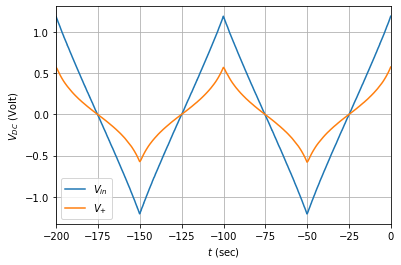

array([3.52986190e+04, 1.15094778e+00])

array([8.66707394e+00, 1.69566767e-03])

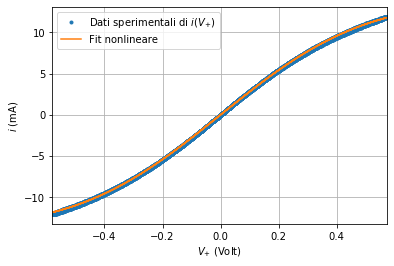

In [27]:
def lampfunc(Vplus, RL, alpha):
    return ((1000 * Vplus)/(RL*(1+alpha*np.power(Vplus, 2))))

ivlampx = pd.read_csv('data/ivlamp1_1.csv', skiprows=[0]).dropna()
ivlampy = pd.read_csv('data/ivlamp1_2.csv', skiprows=[0]).dropna()
ivlampdf = pd.DataFrame({'second': ivlampx['second'], 'Vin': ivlampx['Volt'], 'V+': ivlampy['Volt']})
#display(ivlampdf)

fig1 = plt.figure()
plt.xlabel('$t$ (sec)')
plt.ylabel('$V_{DC}$ (Volt)')
plt.grid()
plt.xlim([-200, 0])
plt.plot(ivlampdf['second'], ivlampdf['Vin'], label='$V_{in}$')
plt.plot(ivlampdf['second'], ivlampdf['V+'], label='$V_{+}$')
plt.legend()
plt.show()

popt1, pcov1 = curve_fit(lampfunc, ivlampdf['V+'], ivlampdf['Vin']/100, p0=[35e3, 2])
display(popt1, np.sqrt(np.diag(pcov1)))

fig2 = plt.figure()
plt.xlabel('$V_{+}$ (Volt)')
plt.ylabel('$i$ (mA)')
plt.xlim(ivlampdf['V+'].min(), ivlampdf['V+'].max())
plt.grid()
plt.plot(ivlampdf['V+'], ivlampdf['Vin']/100*1000, '.', label='Dati sperimentali di $i(V_{+})$')
plt.plot(ivlampdf['V+'], lampfunc(ivlampdf['V+'], *popt1)*1000, label='Fit nonlineare')
plt.legend()
plt.show()

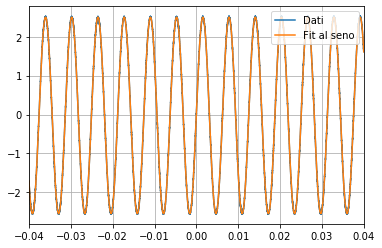

Power_divergenceResult(statistic=-0.4615672190182254, pvalue=1.0)

A 	= (2.52983 +- 0.00006) Volt
omega 	= (1003.030 +- 0.001) rad/sec
phase 	= (0.01342 +- 0.00003) sec
offset 	= (-0.02321 +- 0.00005) Volt


In [177]:
wien1 = pd.read_csv(f'data/wien_1.csv', skiprows=[0]).dropna()
sfit1 = fit_sin(wien1['second'], wien1['Volt'])
#display(sfit1)
sfit1_err = np.sqrt(np.diag(sfit1['rawres'][2]))
fig3 = plt.figure()
plt.grid()
plt.plot(wien1['second'], wien1['Volt'], label='Dati')
plt.plot(wien1['second'], sfit1['fitfunc'](wien1['second']), label='Fit al seno')
plt.legend(loc='upper right')
plt.xlim((-0.04, 0.04))
plt.show()

#chiq2 = chiq(sfit1['fitfunc'](wien1['second']), wien1['Volt'], 3e-2*8*740e-3)
#testchiq(len(wien1['second'])-4, 0, 0.995, chiq2)
#display(len(wien1['second']))
scipy.stats.chisquare(wien1['Volt'], f_exp=sfit1['fitfunc'](wien1['second']))

print('A \t= (%.5f +- %.5f) Volt\nomega \t= (%.3f +- %.3f) rad/sec\nphase \t= (%.5f +- %.5f) sec\noffset \t= (%.5f +- %.5f) Volt' % (sfit1['amp'], sfit1_err[0], sfit1['omega'], sfit1_err[1], sfit1['phase'], sfit1_err[2], sfit1['offset'], sfit1_err[3]))

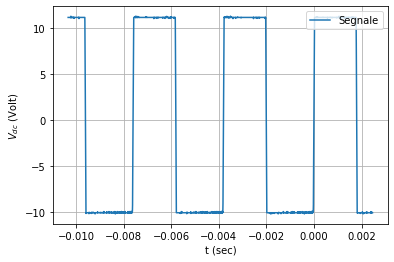

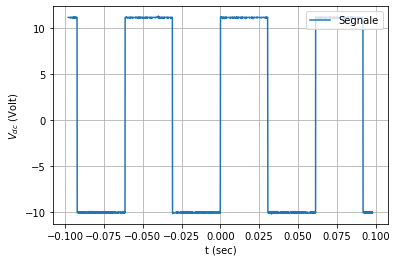

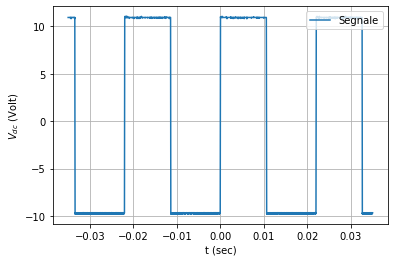

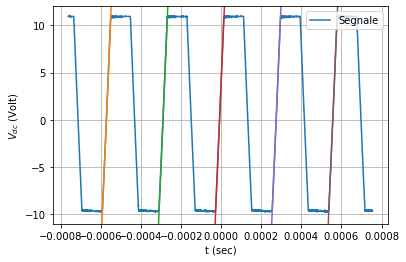

array([0.00073828, 0.00069694, 0.00072468, 0.00073243, 0.00070915])

Le frequenze per le quattro configurazioni sono
R1/R2=0.1 	 (263.6 +- 0.2) Hz
R1/R2=1 	 (16.33 +- 0.01) Hz
R1/R2=1 	 (45.48 +- 0.04) Hz
R1/R2=10 	 (3542.9 +- 0.9) Hz

Lo slew rate è
m = (0.4950 +- 0.0002) Volt/usec


In [150]:
# R1/R2 = 0.1
relax01 = pd.read_csv(f'data/relax_01.csv', skiprows=[0]).dropna()
sfit2 = fit_sin(relax01['second'], relax01['Volt'])
freq01 = sfit2['freq']
dfreq01 = np.sqrt(np.diag(sfit2['rawres'][2]))[1]/(2.*np.pi)
fig4 = plt.figure()
plt.grid()
plt.plot(relax01['second'], relax01['Volt'], label='Segnale')
#plt.plot(relax01['second'], sfit2['fitfunc'](relax01['second']))
plt.legend(loc='upper right')
plt.xlabel('t (sec)')
plt.ylabel('$V_{dc}$ (Volt)')
plt.show()

# R1/R2 = 10
relax10 = pd.read_csv(f'data/relax_10.csv', skiprows=[0]).dropna()
sfit3 = fit_sin(relax10['second'], relax10['Volt'])
freq10 = sfit3['freq']
dfreq10 = np.sqrt(np.diag(sfit3['rawres'][2]))[1]/(2.*np.pi)
fig5 = plt.figure()
plt.grid()
plt.plot(relax10['second'], relax10['Volt'], label='Segnale')
#plt.plot(relax10['second'], sfit3['fitfunc'](relax10['second']))
plt.legend(loc='upper right')
plt.xlabel('t (sec)')
plt.ylabel('$V_{dc}$ (Volt)')
plt.show()

# R1/R2 = 1
relax1_1 = pd.read_csv(f'data/relax_1_1.csv', skiprows=[0]).dropna()
sfit4 = fit_sin(relax1_1['second'], relax1_1['Volt'])
freq1_1 = sfit4['freq']
dfreq1_1 = np.sqrt(np.diag(sfit4['rawres'][2]))[1]/(2.*np.pi)
fig6 = plt.figure()
plt.grid()
plt.plot(relax1_1['second'], relax1_1['Volt'], label='Segnale')
#plt.plot(relax1_1['second'], sfit4['fitfunc'](relax1_1['second']))
plt.legend(loc='upper right')
plt.xlabel('t (sec)')
plt.ylabel('$V_{dc}$ (Volt)')
plt.show()

# R1/R2 = 1 con R1 = 10kOhm e C = 10nF
relax1_2 = pd.read_csv(f'data/relax_1_2.csv', skiprows=[0]).dropna()
sfit5 = fit_sin(relax1_2['second'], relax1_2['Volt'])
freq1_2 = sfit5['freq']
dfreq1_2 = np.sqrt(np.diag(sfit5['rawres'][2]))[1]/(2.*np.pi)
fig7 = plt.figure()
plt.grid()
plt.plot(relax1_2['second'], relax1_2['Volt'], label='Segnale')
dsrvec = []
srvec = []
for ix in ((1120,1390), (3000,3240), (4850,5100), (6700,6970), (8560,8820)):
    popt2, pcov2 = curve_fit(linf, relax1_2['second'][ix[0]:ix[1]], relax1_2['Volt'][ix[0]:ix[1]])
    sr = popt2[0]
    dsr= np.sqrt(np.diag(pcov2))[0]
    srvec.append(sr)
    dsrvec.append(dsr)
    plt.plot(relax1_2['second'], linf(relax1_2['second'], *popt2))
plt.legend(loc='upper right')
plt.xlabel('t (sec)')
plt.ylabel('$V_{dc}$ (Volt)')
plt.ylim((-11,12))
plt.show()
sravg = np.array(srvec).mean()
srstd = np.array(srvec).std()/np.sqrt(12)

display(np.array(dsrvec)*1e-6)

print('Le frequenze per le quattro configurazioni sono\nR1/R2=0.1 \t (%.1f +- %.1f) Hz\nR1/R2=1 \t (%.2f +- %.2f) Hz\nR1/R2=1 \t (%.2f +- %.2f) Hz\nR1/R2=10 \t (%.1f +- %.1f) Hz\n' % (freq01, dfreq01, freq10, dfreq10, freq1_1, dfreq1_1, freq1_2, dfreq1_2))
print('Lo slew rate è\nm = (%.4f +- %.4f) Volt/usec' % (sravg*1e-6, srstd*1e-6))

In [28]:
fig1.savefig('fig1.pdf', bbox_inches='tight')
fig2.savefig('fig2.pdf', bbox_inches='tight')
fig3.savefig('fig3.pdf', bbox_inches='tight')
fig4.savefig('fig4.pdf', bbox_inches='tight')
fig5.savefig('fig5.pdf', bbox_inches='tight')
fig6.savefig('fig6.pdf', bbox_inches='tight')
fig7.savefig('fig7.pdf', bbox_inches='tight')

NameError: name 'fig3' is not defined